In [1]:
%matplotlib inline
import axs
import os

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import ascii

import pyspark.sql.functions as sparkfunc
from pyspark.sql.window import Window
import pyspark.sql.types as sparktypes

In [2]:
from pyspark.sql import SparkSession
spark_session = (SparkSession.builder
         .config('spark.master', "local[20]") # 20 when running the full crossmatch, 10 when doing validation.
         .config('spark.driver.memory', '80G')
         .config("spark.sql.execution.arrow.enabled", "true")
         # uncomment if beta-jupyterhub proxies are working again.  otherwise, tunnel
         #.config("spark.ui.proxyBase", "https://epyc.astro.washington.edu/beta-jupyter/user/ecbellm/proxy/4040")
         .config("spark.port.maxRetries", "128")
         .enableHiveSupport()
         .getOrCreate())
spark_session

https://epyc.astro.washington.edu/beta-jupyter/user/ecbellm/proxy/4051/jobs/

In [3]:
catalog = axs.AxsCatalog(spark_session)

Building the Detection Table
=======

In [4]:

base_path = "/epyc/data/ztf_matchfiles/scratch_dr7_bulk_ztf_parquet_for_axs"
ztf_detections = spark_session.read.parquet(base_path + "/[01]/*/ztf_*_data.parquet")


In [5]:
ztf_detections

DataFrame[objectid: bigint, ra: float, dec: float, mjd_g: array<float>, mag_g: array<float>, magerr_g: array<float>, clrcoeff_g: array<float>, catflags_g: array<smallint>, rcid_g: array<smallint>, fieldid_g: array<smallint>, mjd_r: array<float>, mag_r: array<float>, magerr_r: array<float>, clrcoeff_r: array<float>, catflags_r: array<smallint>, rcid_r: array<smallint>, fieldid_r: array<smallint>, mjd_i: array<float>, mag_i: array<float>, magerr_i: array<float>, clrcoeff_i: array<float>, catflags_i: array<smallint>, rcid_i: array<smallint>, fieldid_i: array<smallint>, __index_level_0__: bigint]

In [9]:
# checks quickly for broken files
ztf_detections.count()

3776776926

Run e.g. `nice ./ztf_make_parquet.py --check-output --glob 0/field0288/ztf_000288_zg_c05_q*` on any files that cause failures during the `.count()`


In [6]:
%%time

catalog.save_axs_table(ztf_detections, "ztf_dr7_detections", calculate_zone=True)

CPU times: user 20.8 s, sys: 11.9 s, total: 32.7 s
Wall time: 1d 8h 14min 29s


Note that this originally looked like it was going to take 100+ days on a second stage, but then it skipped a large computation and finished?

Match in sections
======

In [7]:
ps1 = catalog.load("ps1")

In [8]:
ztf_detections = catalog.load("ztf_dr7_detections")

In [9]:
ztf_detections.columns

['objectid',
 'ra',
 'dec',
 'mjd_g',
 'mag_g',
 'magerr_g',
 'clrcoeff_g',
 'catflags_g',
 'rcid_g',
 'fieldid_g',
 'mjd_r',
 'mag_r',
 'magerr_r',
 'clrcoeff_r',
 'catflags_r',
 'rcid_r',
 'fieldid_r',
 'mjd_i',
 'mag_i',
 'magerr_i',
 'clrcoeff_i',
 'catflags_i',
 'rcid_i',
 'fieldid_i',
 '__index_level_0__',
 'zone',
 'dup']

In [10]:
def crossmatch_in_zone_band(detections_table, ps1, min_zone, max_zone, base_name):
    
    match_result = detections_table.where((detections_table['zone'] >= int(min_zone)) &
                                            (detections_table['zone'] < int(max_zone))).crossmatch(
        ps1.exclude_duplicates().select("ra", "dec", "zone", "dup", "objID",
                                        "gMeanPSFMag", "rMeanPSFMag", "iMeanPSFMag"), return_min=False)

    w = Window.partitionBy(sparkfunc.col("zone"), sparkfunc.col("objectid"),
                           sparkfunc.col("objID")).orderBy(sparkfunc.col("axsdist"))
    best_matches = match_result.withColumn("axsrownum",
                                         sparkfunc.row_number().over(w)).where(
                                         sparkfunc.col("axsrownum") == 1).drop("axsrownum")

    best_matches.createOrReplaceTempView("ztf_best_matches")

    q = spark_session.sql("SELECT objid as ps1_objid, avg(ra) as ra, avg(dec) as dec, zone, "
                          "first(gMeanPSFMag) as ps1_gMeanPSFMag, "
                          "first(rMeanPSFMag) as ps1_rMeanPSFMag, "
                          "first(iMeanPSFMag) as ps1_iMeanPSFMag, "
                          "collect_list(ra) as ra_detections, "
                          "collect_list(dec) as dec_detections, "                      
                          "flatten(collect_list(mjd_g)) as mjd_g, "
                          "flatten(collect_list(mag_g)) as mag_g, "
                          "flatten(collect_list(magerr_g)) as magerr_g, "
                          "flatten(collect_list(catflags_g)) as catflags_g, "
                          "flatten(collect_list(rcid_g)) as rcID_g, "
                          "flatten(collect_list(fieldid_g)) as fieldID_g, "
                          ""
                          "flatten(collect_list(mjd_r)) as mjd_r, "
                          "flatten(collect_list(mag_r)) as mag_r, "
                          "flatten(collect_list(magerr_r)) as magerr_r, "
                          "flatten(collect_list(catflags_r)) as catflags_r, "
                          "flatten(collect_list(rcid_r)) as rcID_r, "
                          "flatten(collect_list(fieldid_r)) as fieldID_r, "                  
                          ""
                          "flatten(collect_list(mjd_i)) as mjd_i, "
                          "flatten(collect_list(mag_i)) as mag_i, "
                          "flatten(collect_list(magerr_i)) as magerr_i, " 
                          "flatten(collect_list(catflags_i)) as catflags_i, "
                          "flatten(collect_list(rcid_i)) as rcID_i, "
                          "flatten(collect_list(fieldid_i)) as fieldID_i "
                          ""
                          "FROM ztf_best_matches "
                          "GROUP BY zone, objid")
    
    q.createOrReplaceTempView('q')
    # mean function from https://stackoverflow.com/questions/55502546/find-mean-of-pyspark-arraydouble
    q2 = spark_session.sql("""SELECT *, cardinality(mjd_g) AS nobs_g,
                        cardinality(mjd_r) AS nobs_r, cardinality(mjd_i) AS nobs_i,
                        aggregate(mag_g, CAST(0.0 AS double), (acc, x) -> acc + x,  acc -> acc / size(mag_g)) AS  mean_mag_g,
                        aggregate(mag_r, CAST(0.0 AS double), (acc, x) -> acc + x,  acc -> acc / size(mag_r)) AS  mean_mag_r,
                        aggregate(mag_i, CAST(0.0 AS double), (acc, x) -> acc + x,  acc -> acc / size(mag_i)) AS  mean_mag_i
                        FROM q""")

    q2.write.parquet("/epyc/projects2/ztf_scratch3/{:s}_zone{:05d}_{:05d}.parquet".format(base_name, min_zone, max_zone))


In [11]:
ztf_detections.select(sparkfunc.min(ztf_detections['zone']),
                                sparkfunc.max(ztf_detections['zone'])).collect()


[Row(min(zone)=3571, max(zone)=10752)]

In [19]:
zone_chunk_starts = np.arange(3700, 10901, 150)

In [20]:
zone_chunk_starts

array([ 3700,  3850,  4000,  4150,  4300,  4450,  4600,  4750,  4900,
        5050,  5200,  5350,  5500,  5650,  5800,  5950,  6100,  6250,
        6400,  6550,  6700,  6850,  7000,  7150,  7300,  7450,  7600,
        7750,  7900,  8050,  8200,  8350,  8500,  8650,  8800,  8950,
        9100,  9250,  9400,  9550,  9700,  9850, 10000, 10150, 10300,
       10450, 10600, 10750, 10900])

In [21]:
%%time
for n, (min_zone, max_zone) in enumerate(zip(zone_chunk_starts[:-1], zone_chunk_starts[1:])):
    print(min_zone, max_zone)
    crossmatch_in_zone_band(ztf_detections, ps1, min_zone, max_zone, "ztf_dr7")

3700 3850
3850 4000
4000 4150
4150 4300
4300 4450
4450 4600
4600 4750
4750 4900
4900 5050
5050 5200
5200 5350
5350 5500
5500 5650
5650 5800
5800 5950
5950 6100
6100 6250
6250 6400
6400 6550
6550 6700
6700 6850
7000 7150
7150 7300
7300 7450
7450 7600
7600 7750
7750 7900
7900 8050
8050 8200
8200 8350
8350 8500
8500 8650
8650 8800
8800 8950
8950 9100
9100 9250
9250 9400
9400 9550
9550 9700
9700 9850
9850 10000
10000 10150
10150 10300
10300 10450
10450 10600
10600 10750
10750 10900
CPU times: user 18.6 s, sys: 10.9 s, total: 29.5 s
Wall time: 1d 1h 28min 28s


Combine strips
========

In [22]:
union_of_shards = spark_session.read.parquet("/epyc/projects2/ztf_scratch3/ztf_dr7*.parquet")

In [23]:
union_of_shards

DataFrame[ps1_objid: bigint, ra: double, dec: double, zone: bigint, ps1_gMeanPSFMag: double, ps1_rMeanPSFMag: double, ps1_iMeanPSFMag: double, ra_detections: array<float>, dec_detections: array<float>, mjd_g: array<float>, mag_g: array<float>, magerr_g: array<float>, catflags_g: array<smallint>, rcID_g: array<smallint>, fieldID_g: array<smallint>, mjd_r: array<float>, mag_r: array<float>, magerr_r: array<float>, catflags_r: array<smallint>, rcID_r: array<smallint>, fieldID_r: array<smallint>, mjd_i: array<float>, mag_i: array<float>, magerr_i: array<float>, catflags_i: array<smallint>, rcID_i: array<smallint>, fieldID_i: array<smallint>, nobs_g: int, nobs_r: int, nobs_i: int, mean_mag_g: double, mean_mag_r: double, mean_mag_i: double]

In [25]:
union_of_shards.head()

Row(ps1_objid=76480025320151561, ra=2.532028913497925, dec=-26.265743255615234, zone=3824, ps1_gMeanPSFMag=22.206499, ps1_rMeanPSFMag=21.025, ps1_iMeanPSFMag=20.178301, ra_detections=[2.532028913497925], dec_detections=[-26.265743255615234], mjd_g=[58694.44140625, 58708.421875], mag_g=[21.69381332397461, 17.597698211669922], magerr_g=[0.2576265335083008, 0.03502609208226204], catflags_g=[0, -1], rcID_g=[4, 4], fieldID_g=[245, 245], mjd_r=[], mag_r=[], magerr_r=[], catflags_r=[], rcID_r=[], fieldID_r=[], mjd_i=[], mag_i=[], magerr_i=[], catflags_i=[], rcID_i=[], fieldID_i=[], nobs_g=2, nobs_r=0, nobs_i=0, mean_mag_g=19.645755767822266, mean_mag_r=None, mean_mag_i=None)

In [26]:
catalog.drop_table("ztf_dr7")

Table or view not found: ztf_dr7;


In [27]:
%%time
catalog.save_axs_table(union_of_shards.drop("zone"), "ztf_dr7", calculate_zone=True)

CPU times: user 16 s, sys: 9.51 s, total: 25.5 s
Wall time: 22h 50min 49s


Validation
======

In [28]:
ztf_det = catalog.load("ztf_dr7_detections")

In [29]:
ztf_det.count()

4406263507

In [30]:
ztf = catalog.load("ztf_dr7")

In [31]:
ztf.count()

1349173381

In [32]:
ztf.exclude_duplicates().count()

1156176353

In [164]:
ztf

AxsFrame[ps1_objid: bigint, ra: double, dec: double, ps1_gMeanPSFMag: double, ps1_rMeanPSFMag: double, ps1_iMeanPSFMag: double, ra_detections: array<float>, dec_detections: array<float>, mjd_g: array<float>, mag_g: array<float>, magerr_g: array<float>, catflags_g: array<smallint>, rcID_g: array<smallint>, fieldID_g: array<smallint>, mjd_r: array<float>, mag_r: array<float>, magerr_r: array<float>, catflags_r: array<smallint>, rcID_r: array<smallint>, fieldID_r: array<smallint>, mjd_i: array<float>, mag_i: array<float>, magerr_i: array<float>, catflags_i: array<smallint>, rcID_i: array<smallint>, fieldID_i: array<smallint>, nobs_g: int, nobs_r: int, nobs_i: int, mean_mag_g: double, mean_mag_r: double, mean_mag_i: double, zone: bigint, dup: int]

In [44]:
# need to replace this with region to be faster
dflc = ztf.cone(284.6728604,22.6582771,2/3600).exclude_duplicates().select('*').toPandas()

In [45]:
dflc[['ps1_objid','ra','dec','nobs_g','nobs_r','nobs_i']]

,ps1_objid,ra,dec,nobs_g,nobs_r,nobs_i
0,135192846728780490,284.672943,22.658257,1,125,0


In [46]:
dflc

,ps1_objid,ra,dec,ps1_gMeanPSFMag,ps1_rMeanPSFMag,ps1_iMeanPSFMag,ra_detections,dec_detections,mjd_g,mag_g,...,rcID_i,fieldID_i,nobs_g,nobs_r,nobs_i,mean_mag_g,mean_mag_r,mean_mag_i,zone,dup
0,135192846728780490,284.672943,22.658257,-999.0,21.8995,21.300699,"[284.673, 284.67288]","[22.658197, 22.658316]",[58693.316],[22.095587],...,[],[],1,125,0,22.095587,20.588129,NaN,6759,0


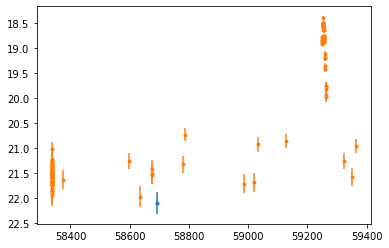

In [47]:
plt.figure()
lc = dflc.loc[0]

plt.errorbar(lc['mjd_g'],lc['mag_g'],lc['magerr_g'],fmt='.',ls='none')
plt.errorbar(lc['mjd_r'],lc['mag_r'],lc['magerr_r'],fmt='.',ls='none')
plt.gca().invert_yaxis()

In [48]:

def histogram2d(axsframe, cond1, cond2, numbins1, numbins2, min1=None, max1=None, min2=None, max2=None):
    """
    Uses `cond1` and `cond2` colunm expressions to obtain data for 2D histogram calculation. The data on
    x axis will be binned into `numbins1` bins. The data on y axis will be binned into `numbins2` bins.
    If `min1`, `max1`, `min2` or `max2` are not spacified, they will be calculated using an additional pass
    through the data.
    The method returns x, y and z 2-D numpy arrays (see numpy.mgrid) which can be used as an input to
    `matplotlib.pcolormesh`.
    :param cond1: Column expression determining the data on x axis.
    :param cond2: Column expression determining the data on y axis.
    :param numbins1: Number of bins for x axis.
    :param numbins2: Number of bins for y axis.
    :param min1: Optional minimum value for x axis data.
    :param max1: Optional maximum value for x axis data.
    :param min2: Optional minimum value for y axis data.
    :param max2: Optional maximum value for y axis data.
    :return: x, y, z 2-D numpy "meshgrid" arrays (see numpy.mgrid)
    """
    colname1 = "axs_hist_col1"
    colname2 = "axs_hist_col2"
    res = axsframe._df.select(cond1.alias(colname1), cond2.alias(colname2))

    if min1 is None or max1 is None or min2 is None or max2 is None:
        mm = res.select(F.min(res[colname1]).alias("min1"), F.max(res[colname1]).alias("max1"),
                        F.min(res[colname2]).alias("min2"), F.max(res[colname2]).alias("max2")).\
            collect()
        (min1, max1, min2, max2) = (mm[0]["min1"], mm[0]["max1"], mm[0]["min2"], mm[0]["max2"])

    range1 = float(max1 - min1)
    range2 = float(max2 - min2)
    step1 = range1 / numbins1
    step2 = range2 / numbins2

    hist2d = res.withColumn("bin1", ((res[colname1]-min1)/step1).cast("int")) \
        .withColumn("bin2", ((res[colname2]-min2)/step2).cast("int")).\
        groupBy("bin1", "bin2").count().toPandas()

    bin1 = np.array(hist2d['bin1'], dtype='int')
    bin2 = np.array(hist2d['bin2'], dtype='int')
    vals = np.array(hist2d['count'], dtype='int')

    x, y = np.mgrid[slice(min1, max1 + step1, step1),
                    slice(min2, max2 + step2, step2)]

    z = np.zeros(numbins1*numbins2)
    ok_bins, = np.where((bin1 >= 0) & (bin1 < numbins1) & (bin2 >= 0) & (bin2 < numbins2))
    bin_onedim_index = bin2 + bin1*numbins2
    z[bin_onedim_index[ok_bins]] = vals[ok_bins]
    
    return x, y, z.reshape((numbins1, numbins2))


In [49]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120

In [55]:
ztf.select(sparkfunc.min('dec')).collect()

[Row(min(dec)=-28.333279609680176)]

CPU times: user 160 ms, sys: 66.6 ms, total: 227 ms
Wall time: 27.6 s


Text(0, 0.5, 'Dec')

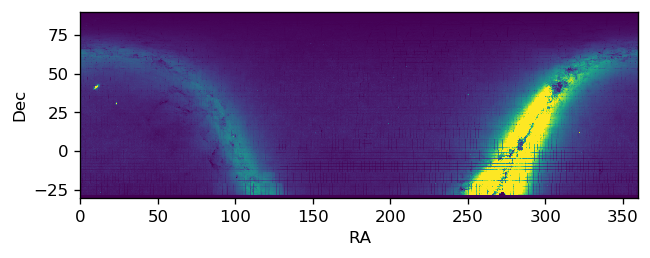

In [57]:
%%time
x,y,hist = histogram2d(ztf, ztf['ra'], ztf['dec'], 1200, 360, min1=0, max1=360, min2=-30, max2=90)

Text(0, 0.5, 'Dec')

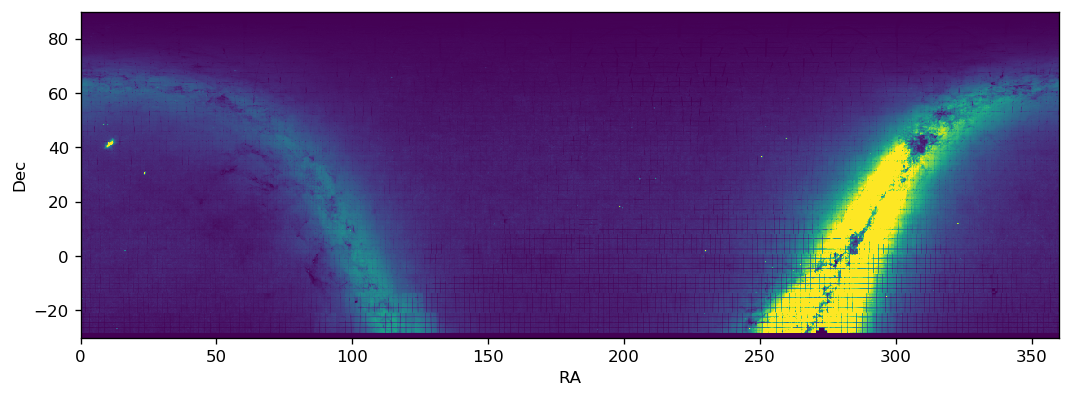

In [63]:
mult=1
plt.figure(figsize=(12*mult,3.6*mult))
extent = (0, 360, -30, 90)
plt.imshow(hist.T, origin='lower', extent=extent, interpolation=None, vmax=0.4*np.max(hist))
plt.xlabel("RA")
plt.ylabel("Dec")

In [65]:
catalog.list_table_names()

['gaia_dr2_1am_dup',
 'allwise_1am_dup',
 'unwise_v1',
 'cklein_flare',
 'unwise_v2',
 'catalina_variables_n',
 'gaia',
 'gaia_dr2_1am_dup_ssd',
 'ztf_dr3_detections',
 'ps1',
 'gaia_dr2_wds_j2019',
 'gaia_dr2_wds_j2019_fall2020temp',
 'green19_stellar_params',
 'rosat_2rxs',
 'ztf_dr3',
 'rosat_2rxs_z4am_b2am',
 'ztf_dr3_2rxs_obj',
 'wtf_ztf_dr3',
 'ztf_wds_kjb_dr3',
 'ztf_aug2020_combined',
 'karenws_cut_wtf_fits_r_band',
 'karenws_cut_wtf_fits',
 'ztf_aug2020_combined_z4am_b2am',
 'ztf_aug2020_2rxs_obj',
 'skymapper_dr2',
 'test_skymapper',
 'skymapper_dr2_ver2',
 'skymapper_dr2_ver3',
 'ztf_rrlyr',
 'gaia_source_edr3',
 'gaia_edr3_distances',
 'rrlyrae_sample_andy',
 'stevengs_test_small_df',
 'ztf5',
 'ztf_wds_expected_kjb',
 'ztf_dr4_detections',
 'ztf_wds_kjb',
 'feh_rrlyr_ab_020620',
 'kepler_rrlyrae',
 'ztf_kepler_rrlyrae',
 'ps_uband',
 'ps_uband_ver2',
 'debug_match_a',
 'debug_match_b',
 'debug_match_c',
 'gaia_dr2_wds_j2019_spring2021temp',
 'temp_kjb',
 'ztf_rrlyr_grid_50

In [73]:
wds = catalog.load("gaia_dr2_wds_j2019")

In [74]:
%%time
xmatch = wds.crossmatch(ztf, return_min=True)

x,y,hist = histogram2d(xmatch, xmatch['ra'], xmatch['dec'], 1200, 3600, min1=0, max1=360, min2=-30, max2=90)


CPU times: user 447 ms, sys: 0 ns, total: 447 ms
Wall time: 1min 35s


Text(0, 0.5, 'Dec')

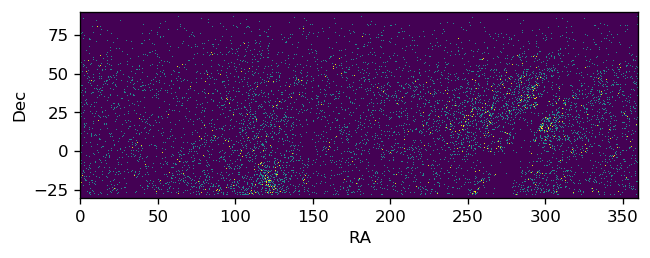

In [75]:
extent = (0, 360, -30, 90)
plt.imshow(hist.T, origin='lower', extent=extent, interpolation=None, vmax=0.1*np.max(hist))
plt.xlabel("RA")
plt.ylabel("Dec")